In [2]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

sys.path.append(str(Path.cwd()))

from plotting_constants import coarse_regions, colors, min_cost_acceleration_factor
idx = pd.IndexSlice

In [3]:
# root = str(Path.cwd().parent.parent.parent / "cluster_data" / "{}_data")
root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep"

app = "dh"

In [4]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def get_cm(color, factor=2., name="itsacminnit", show=False, asymetric=False):
    """returns colormap between darker and lighter version passed color"""

    if not asymetric:
        colors = [adjust_lightness(color, amount=factor), adjust_lightness(color, amount=1/factor)]
    else:
        colors = [adjust_lightness(color, amount=factor), color]

    cm = LinearSegmentedColormap.from_list(
            name, colors, N=20)

    if show:
        plt.imshow(np.indices((10,10))[1], cmap=cm)
        plt.show()

    return cm

In [5]:
from pyproj import CRS

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap.index = worldmap.name

other_countries = ["Russia", "Ukraine", "Moldova", "Belarus", "Morocco", "Algeria", "Libya", "Egypt", "Tunisia", "Turkey"]

regions = gpd.read_file(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "resources" /
    "regions_onshore_elec_s_72.geojson"
    ).set_crs("EPSG:4326")

# group regions to countries
regions["country"] = regions["name"].apply(lambda x: x[:2])
countries = regions.dissolve(by="country")

col = 0.1

cmap_kwargs = {
    "elec": dict(factor=2.5, asymetric=False),
    "dh": dict(factor=3, asymetric=True),
    "chp": dict(factor=1.5, asymetric=False),
}

regions = regions.set_index("name")
regions["name"] = regions.index

C:\Users\lukas\AppData\Local\Temp\ipykernel_24580\2075053883.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


NameError: name 'show_regions' is not defined

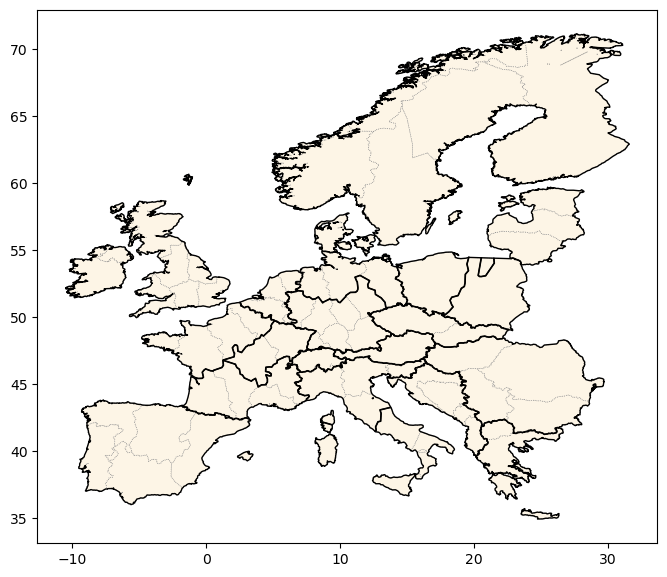

In [6]:
from shapely.ops import unary_union

fig, ax = plt.subplots(1, 1, figsize=(8, 7))

def plot_coarse_regions(ax):
    regions.plot(
        ax=ax,
        color="oldlace",
        edgecolor="grey",
        alpha=1,
        linewidth=0.5,
        label="name",
        linestyle=":"
        )

    for _, buses in coarse_regions.items():

        region = regions.loc[buses]
        poly = unary_union(region.geometry).buffer(0.01)
        gpd.GeoSeries([poly]).plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1.)
    
    for region_name, color in zip(show_regions, region_colors):
        region = regions.loc[coarse_regions[region_name]]
        poly = unary_union(region.geometry).buffer(0.01)
        gpd.GeoSeries([poly]).plot(ax=ax, facecolor=color, edgecolor="k", linewidth=1., alpha=0.5)

    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

plot_coarse_regions(ax)

plt.show()

In [9]:
years = list(range(1990, 2055, 5))

capex_template = str(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "breyer_sweep" /
    "egs_costs_s_72_{}.csv"
    )

year_costs = list()

for year in years:

    capex = pd.read_csv(capex_template.format(year)).set_index("name")["capex_mean"]
    year_costs.append(capex)


year_costs = pd.concat(year_costs, axis=1).T
year_costs.index = years
year_costs = year_costs.T

year_costs

,1990,1995,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
name,,,,,,,,,,,,,
AL1 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AT1 0,18365.873579,12800.856025,9594.052111,7190.600046,5389.248298,4039.161827,2796.735173,1978.614086,1529.991367,1107.520773,807.055099,636.202388,558.441477
BA1 0,40698.925652,29539.147978,22139.154168,16592.968344,12436.184163,9320.735949,6386.002195,4517.922904,3493.547878,2528.888025,1842.811462,1452.690225,1275.132709
BE1 0,29372.306209,21050.014363,15776.674181,11824.383771,8862.200611,6642.088179,4565.639196,3230.065582,2497.693962,1808.015396,1317.508511,1038.593353,911.649527
BG1 0,29182.557085,20907.800203,15670.086773,11744.498087,8802.327473,6597.214148,4535.143576,3208.490760,2481.010926,1795.938982,1308.708376,1031.656198,905.560277
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RS1 0,28224.962868,20190.097512,15132.179230,11341.344345,8500.169711,6370.751378,4381.243369,3099.610548,2396.817760,1734.993749,1264.297326,996.646920,874.830067
SE2 0,35600.278019,25717.787047,19275.100715,14446.402674,10827.364968,8114.949776,5566.570630,3938.197354,3045.266885,2204.389127,1606.347735,1266.285619,1111.511721
SE2 1,36065.237983,26066.267658,19536.281775,14642.154012,10974.077698,8224.908795,5641.296891,3991.064151,3086.146885,2233.981091,1627.911524,1283.284377,1126.432777


In [108]:
metrics = {
    "elec": "AC_geothermal_generation_share",
    "chp": "uch_geothermal_generation_share",
    "dh": "uch_geothermal_generation_share",
}

def get_data(app, do_plot=False):

    header = [4,5,6,7,8]

    df = pd.read_csv(
        root / 
        "joint_data" /
        "nodal_geothermal_stats.csv", 
        index_col=[0,1], 
        header=header,
        ).sort_index()
    
    df = df.loc[:,idx[:,app]]

    this = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]

    totals = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]
    totals.index = totals.index.droplevel(1)

    this.columns = this.columns.get_level_values(0)
    this.index = this.index.get_level_values(0)

    this.columns = this.columns.to_numpy().astype(int)
    # this = this.loc[:,::-1]

    # print(this.head().T.head().T)

    def flip_transform(arr):
        return - (arr - arr.min()) + arr.max()
        # return - (arr - arr.min()) + 1.

    data = pd.DataFrame(index=this.index.unique(), columns=[0.1, 0.2, 0.3])
    progress_year_data = pd.DataFrame(index=this.index.unique(), columns=[0.1, 0.2, 0.3])
    ever_never_data = pd.DataFrame('eventually', index=this.index.unique(), columns=[0.1, 0.2, 0.3])

    # print('data')
    # print(data)
    # print('this')
    # print(this)

    this = this[sorted(this.columns)]
    xyears = np.linspace(min(this.columns), max(this.columns), 200)[::-1]

    # print('year costs')
    # print(year_costs)

    # for bus, thresh in product(data.index[1:], [0.1]):
    for bus, thresh in product(data.index[1:], data.columns):

        # bus = 'AT1 0'

        xp = year_costs.loc[bus, this.columns].values[::-1]
        x = np.linspace(xp.min(), xp.max(), 200)
        
        # print(bus)
        # print('years')
        # print(this.columns.values)

        yp = this.loc[bus].values.astype(float)[::-1]
        # print(this.loc[bus])
        

        y = np.interp(x, xp, flip_transform(yp))
        y = flip_transform(y)

        yy = np.interp(xyears, this.columns.values, yp)

        try:

            # data.loc[bus, thresh] = x[len(y[y > 1 - thresh])]
            # progress_year_data.loc[bus, thresh] = xyears[::-1][len(yy[yy < 1 - thresh])]

            data.loc[bus, thresh] = x[len(y[y > thresh])]
            progress_year_data.loc[bus, thresh] = xyears[::-1][len(yy[yy < thresh])]

        except IndexError:

            # if len(y[y > y - thresh]) == len(y):
            if len(y[y > thresh]) == len(y):
                # data.loc[bus, thresh] = y[-1]
                data.loc[bus, thresh] = max(xp)
                progress_year_data.loc[bus, thresh] = 2020

            # elif len(y[y > 1 - thresh]) == 0:
            elif len(y[y > thresh]) == 0:
                data.loc[bus, thresh] = 0
                progress_year_data.loc[bus, thresh] = 2050
                ever_never_data.loc[bus, thresh] = 'never'
        

        if do_plot:

            _, axs = plt.subplots(1, 2, figsize=(12, 5))

            axs[0].scatter(xp, yp, label="data")

            axs[0].scatter(xp, flip_transform(yp), label="flipped data")

            axs[0].plot(x, y, label="interpolated")
            axs[0].axvline(data.loc[bus, thresh], label="hit", color="k", linestyle="--")

            axs[1].scatter(this.columns.values, yp, label="data")
            axs[1].plot(xyears[::-1], yy, label="interpolated")
            axs[1].axvline(progress_year_data.loc[bus, thresh], color="k", linestyle="--")

            for ax in axs:
                ax.legend()
                ax.axhline(thresh, color="k", linestyle="--")
            
            print(bus, data.loc[bus, thresh], progress_year_data.loc[bus, thresh])

            plt.show()
        

    data.columns = data.columns.to_numpy()
    return data, progress_year_data, ever_never_data

capex, year, ever = get_data("dh", do_plot=False)

C:\Users\lukas\AppData\Local\Temp\ipykernel_24580\2532256888.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["250", "", "1500"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_24580\2532256888.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5350"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_24580\2532256888.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5500"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_24580\2532256888.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


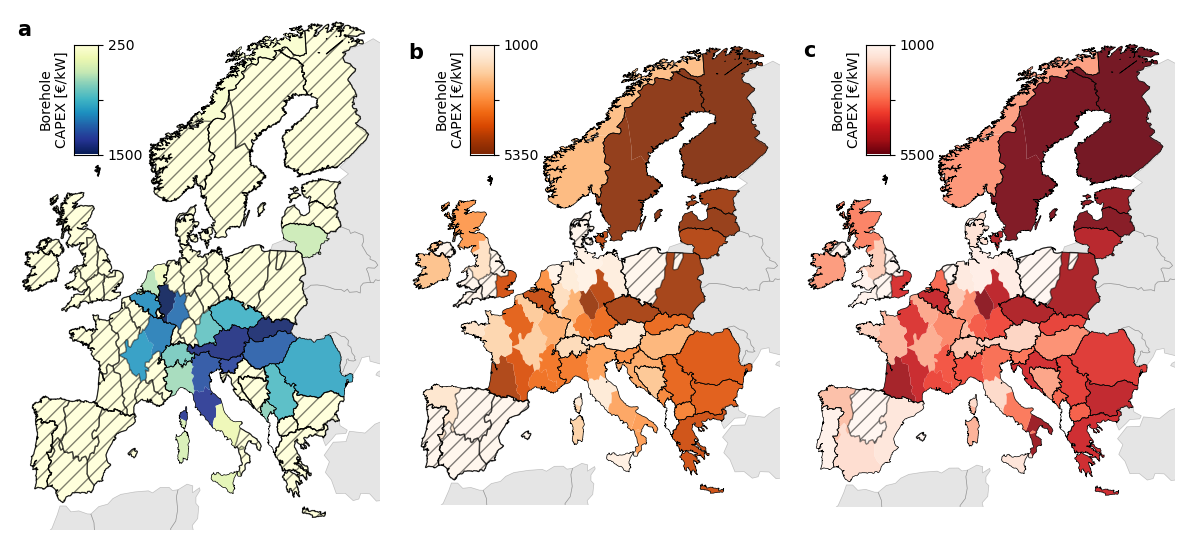

In [120]:
def plot_regions(col, ax, mode='capex', thresh=0.1, plot_nevers=False):

    assert col in ["elec", "chp", "dh"]

    color = colors[col]
    capex_threshold, year_threshold, ever = get_data(col)

    capex_threshold = capex_threshold[thresh]
    year_threshold = year_threshold[thresh]
    ever = ever[thresh]

    year_threshold = - (year_threshold - 2020) + 2050

    regions[col] = locals()[mode + "_threshold"]
    regions[col+'_ever'] = ever

    if mode == "year":
        vmin = 2020
        vmax = 2050

        if col == "elec":
            cmap = "YlGnBu"
        elif col == "dh":
            cmap = "Reds"
        elif col == "chp":
            cmap = "Oranges"

    elif mode == "capex":
        vmin = regions[col].min()
        vmax = regions[col].max()
        # cmap = get_cm(color, **cmap_kwargs[col])
        # cmap = get_cm(color, **cmap_kwargs[col])
        if col == "elec":
            cmap = "YlGnBu"
        elif col == "dh":
            cmap = "Reds"
        elif col == "chp":
            cmap = "Oranges"
    
    regions.plot(
        ax=ax,
        column=col,
        label=f"10%",
        cmap=cmap,
        alpha=0.9,
        )
    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    countries.plot(
        ax=ax,
        color="none",
        edgecolor="black",
        linewidth=0.5,
        )
    
    if plot_nevers:
        
        regions.loc[regions[col+"_ever"] == "never"].plot(
            ax=ax,
            facecolor="none",
            edgecolor="k",
            hatch='//',
            alpha=0.5,
            )


    cax_lims = {
        "elec": [0.07, 0.71, 0.02, 0.2],
        "chp": [0.40, 0.71, 0.02, 0.2],
        "dh": [0.73, 0.71, 0.02, 0.2],
    }

    cax = fig.add_axes(cax_lims.get(col, [0.35, 0.67, 0.02, 0.18]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cax.set_xticks([])

    y = np.atleast_2d(np.linspace(vmin, vmax, 100)).T
    y = np.hstack((y, y))

    cax.imshow(y, aspect='auto', cmap=cmap)# , vmin=vmin, vmax=vmax)
    
    if mode == "capex":
        cax.set_ylabel("Borehole\nCAPEX [{}/kW]".format(u"\N{euro sign}"))
    elif mode == "year":
        cax.set_ylabel("Cost Reduction Factor/\nCost Progress Year")

    cax.yaxis.set_major_locator(plt.LinearLocator(numticks=3))
    if col == "elec" and mode == "capex":
        cax.set_yticklabels(["250", "", "1500"])
    elif col == "dh" and mode == "capex":
        cax.set_yticklabels(["1000", "", "5500"])
    elif col == "chp" and mode == "capex":
        cax.set_yticklabels(["1000", "", "5350"])
    elif mode == "year":
        cax.set_yticklabels(["5./\n2050", "2.5/\n2035", "1./\n2020"])
    else:
        print(cax.get_yticklabels())
        print(regions[col].min())
        print(regions[col].max())

    cax.yaxis.set_ticks_position("right")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)

fig, axs = plt.subplots(1, 3, figsize=(12, 5.5))
# ax.set_facecolor(adjust_lightness("brown", amount=1, asymetric=True))

mode = 'capex'
thresh = 0.1

plot_regions("elec", axs[0], mode=mode, thresh=thresh, plot_nevers=True)
plot_regions("chp", axs[1], mode=mode, thresh=thresh, plot_nevers=True)
plot_regions("dh", axs[2], mode=mode, thresh=thresh, plot_nevers=True)
# plot_coarse_regions(axs[-1,-1])

for ax, label in zip(axs.flatten(), ["a", "b", "c", "d"]):
    ax.text(0.02, 0.95, label, fontsize=15, weight="bold", transform=ax.transAxes)

plt.tight_layout()
plt.savefig(f"geothermal_maps_{mode}.pdf", bbox_inches="tight")
plt.show()

In [49]:
import pypsa


nfile = (
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "dump" /
    "elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2045_dh_static_0.3_True.nc"
)

n = pypsa.Network(nfile)


INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2045_dh_static_0.3_True.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [62]:
ss = (l := n.loads_t.p_set)[l.columns[l.columns.str.contains("urban central heat")]]
ss.columns = ss.columns.str[:5]

In [102]:
# n.links.carrier.unique()

costs = n.links.loc[n.links.carrier == 'injection geothermal heat']['capital_cost']
costs.index = costs.index.str[:5]
costs = (costs - costs.min()) / (costs.max() - costs.min())

costs = costs.clip(0, 0.15)
costs = 1 - (costs - costs.min()) / (costs.max() - costs.min())

C:\Users\lukas\AppData\Local\Temp\ipykernel_24580\4000594040.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([str(int(vmin)), "", str(int(vmax))])
C:\Users\lukas\AppData\Local\Temp\ipykernel_24580\4000594040.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["Low", "", "High"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_24580\4000594040.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


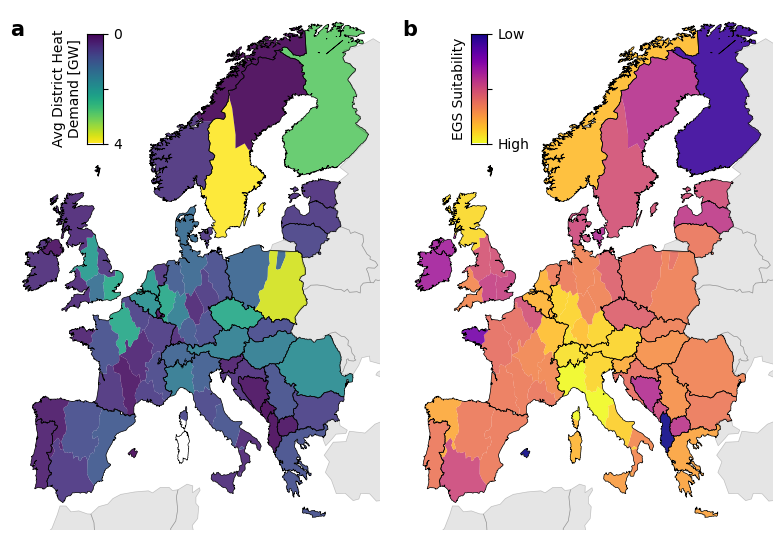

In [101]:
loads = regions[['geometry']]
loads = pd.concat((
    loads,
    ss.sum().rename('avg_district_heat_load') / 8760 * 180 * 1e-3,
    costs.rename('capex')
    ), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 5.5))

cax_lims = {
    "avg_district_heat_load": [0.12, 0.73, 0.02, 0.2],
    "capex": [0.6, 0.73, 0.02, 0.2],
}

for ax, col, cmap in zip(
    axs,
    ["avg_district_heat_load", "capex"],
    ['viridis', 'plasma']
    ):

    vmin = loads[col].min()
    vmax = loads[col].max()

    cax = fig.add_axes(cax_lims[col])
    cax.set_xticks([])

    y = np.atleast_2d(np.linspace(vmin, vmax, 100)).T
    y = np.hstack((y, y))

    cax.imshow(y, aspect='auto', cmap=cmap)# , vmin=vmin, vmax=vmax)

    cax.yaxis.set_major_locator(plt.LinearLocator(numticks=3))

    if col == "avg_district_heat_load":
        cax.set_yticklabels([str(int(vmin)), "", str(int(vmax))])
        cax.set_ylabel("Avg District Heat\nDemand [GW]")

    elif col == "capex":
        cax.set_yticklabels(["Low", "", "High"])
        cax.set_ylabel("EGS Suitability")

    cax.yaxis.set_ticks_position("right")

    loads.plot(
        ax=ax,
        column=col,
        label=f"10%",
        cmap=cmap,
        alpha=0.9,
        )
    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    countries.plot(
        ax=ax,
        color="none",
        edgecolor="black",
        linewidth=0.5,
        )


for ax, label in zip(axs.flatten(), ["a", "b", "c", "d"]):
    ax.text(0.0, 0.95, label, fontsize=15, weight="bold", transform=ax.transAxes)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)

plt.tight_layout()
plt.savefig(f"dh_demand_and_suitability.pdf", bbox_inches="tight")
plt.show()

In [166]:
# regions.loc[['DE1 1', 'CZ1 0'], 'elec']
# regions.loc[regions['elec'] > 0]

,geometry,country,name,elec,chp,dh
name,,,,,,
DE1 1,"MULTIPOLYGON (((6.70097 49.17287, 6.70252 49.2...",DE,DE1 1,898.54572,1187.430939,1548.537463
FR1 0,"POLYGON ((2.48152 46.09750, 2.28900 46.23176, ...",FR,FR1 0,968.016748,2637.252213,2729.257317
HU1 0,"POLYGON ((19.08848 46.01885, 19.04972 45.99311...",HU,HU1 0,826.169454,2488.386948,1854.490446
IT1 0,"MULTIPOLYGON (((11.66859 42.26228, 11.65821 42...",IT,IT1 0,831.189545,2391.399867,0.911066
IT1 4,"MULTIPOLYGON (((14.65895 36.75381, 14.58220 36...",IT,IT1 4,450.437962,0.953974,0.904816
ME1 0,"POLYGON ((19.27493 42.19128, 19.28206 42.16456...",ME,ME1 0,896.202314,2839.42051,2839.42051


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:

ss = []

for year in np.arange(2025, 2055, 5, dtype=int):

    df = pd.read_csv(
        Path.cwd() / "egs_cost_data" / "egs_costs_s_72_{}.csv".format(year)
        ).set_index("name")[['capex_mean']].rename(columns={'capex_mean': year})
    ss.append(df)
    # print(df)

pd.concat(ss, axis=1)

,2025,2030,2035,2040,2045,2050
name,,,,,,
AL1 0,NaN,NaN,NaN,NaN,NaN,NaN
AT1 0,1978.614086,1529.991367,1107.520773,807.055099,636.202388,558.441477
BA1 0,4517.922904,3493.547878,2528.888025,1842.811462,1452.690225,1275.132709
BE1 0,3230.065582,2497.693962,1808.015396,1317.508511,1038.593353,911.649527
BG1 0,3208.490760,2481.010926,1795.938982,1308.708376,1031.656198,905.560277
...,...,...,...,...,...,...
RS1 0,3099.610548,2396.817760,1734.993749,1264.297326,996.646920,874.830067
SE2 0,3938.197354,3045.266885,2204.389127,1606.347735,1266.285619,1111.511721
SE2 1,3991.064151,3086.146885,2233.981091,1627.911524,1283.284377,1126.432777


In [13]:
get_data('dh')[0.1]

NameError: name 'get_data' is not defined

C:\Users\lukas\AppData\Local\Temp\ipykernel_11168\1193414596.py:197: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "10", "20"])


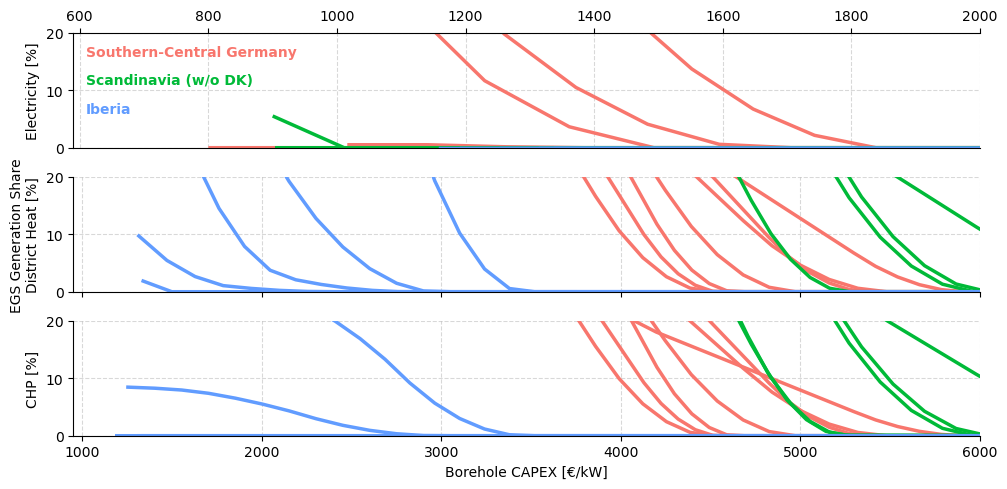

In [79]:
from matplotlib.ticker import LinearLocator
from matplotlib.pyplot import subplots_adjust
from scipy.interpolate import make_interp_spline, BSpline

fig, axs = plt.subplots(3, 1, figsize=(10, 5))

show_regions = {
    "elec": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Romania, Bulgaria, Serbia, Hungary",
        "Scandinavia (w/o DK)",
        ],
    "dh": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Scandinavia (w/o DK)",
        "Eastern Poland",
        "Western Poland",
        ],
    "chp": [
        "Southern-Central Germany",
        "Iberia",
        "Austria",
        "Northern Germany",
        "Scandinavia (w/o DK)",
        "Eastern Poland",
        "Western Poland",
        ]
}

text_pos = {
    "elec": {
        "Iberia": (580,0.1),
        "Southern-Central Germany": (1600,0.06),
        "Austria": (1320,0.16),
        "Romania, Bulgaria, Serbia, Hungary": (1110,0.14),
        "Northern Germany": (1040,0.05),
        "Scandinavia (w/o DK)": (690,0.145),
    },
    "dh": {
        "Western Poland": (1700, 0.04),
        # "Northern Germany": (2000, 0.18),
        "Iberia": (3690, 0.1),
        "Scandinavia (w/o DK)": (5850,0.145),
        "Eastern Poland": (5140, 0.10),
        "Northern Germany": (2400,0.08),
        "Southern-Central Germany": (4190,0.1),
        "Austria": (4720,0.09),
    },
    "chp": {
        "Western Poland": (2000, 0.16),
        "Scandinavia (w/o DK)": (5590,0.145),
        "Eastern Poland": (4820, 0.02),
        "Southern-Central Germany": (4620,0.12),
        "Austria": (3840,0.17),
        "Iberia": (3170,0.17),
        "Northern Germany": (3000, 0.062),
    },
}

renames = {
    "elec": {
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Romania, Bulgaria, Serbia, Hungary": "Romania, Bulgaria,\nSerbia, Hungary",
        "Northern Germany": "Northern\nGermany",
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
    },
    "dh": {
        "Northern Germany": "Northern\nGermany",
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
        "Eastern Poland": "Eastern\nPoland",
    },
    "chp": {
        "Scandinavia (w/o DK)": "Scandinavia\n(w/o DK)",
        "Eastern Poland": "Eastern\nPoland",
        "Southern-Central Germany": "South-\nCentral\nGermany",
        "Northern Germany": "Northern\nGermany",
    },
}

apps = ["elec", "dh", "chp"]

region_colors = [
    "#F8766D", "#00BA38", "#619CFF"
    ]
show_regions = [
    "Southern-Central Germany",
    "Scandinavia (w/o DK)",
    "Iberia",
]


for i, app in enumerate(apps):

    header = [4,5,6,7,8]

    df = pd.read_csv(
        root /
        "joint_data" /
        "nodal_geothermal_stats.csv", 
        index_col=[0,1], 
        header=header,
        ).sort_index()
    # color = colors[app]
    # cmap = get_cm(color, **cmap_kwargs[app])

    df = df.loc[:,idx[:,app]]

    totals = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]
    totals.index = totals.index.droplevel(1)

    metric = metrics[app].split("_")[0]


    # for (region_name, buses), color in zip(coarse_regions.items(), colors):
    for region_name , color in zip(show_regions, region_colors):
        buses = coarse_regions[region_name]

        # if region_name not in show_regions[app]:
            # continue

        total = df.loc[idx[buses, f"{metric}_total_generation"], idx[:,:,"static",:,:]]
        geogen = df.loc[idx[buses, f"{metric}_geothermal_generation"], idx[:,:,"static",:,:]]

        def reduce_ind(df):
            df.columns = df.columns.get_level_values(0)
            df.index = df.index.get_level_values(0)
            return df
        
        # total = reduce_ind(total).sum()
        # geogen = reduce_ind(geogen).sum()
        total = reduce_ind(total)
        geogen = reduce_ind(geogen)

        for bus in buses:

            if year_costs.loc[bus].isna().any():
                continue

            # x = geogen.index.to_numpy().astype(float)

            x = year_costs.loc[bus, total.columns.astype(int)].to_numpy().astype(float)
            y = (geogen.loc[bus] / total.loc[bus]).values
            # print(x, y)
            thresh = 0.1

            x = x[::-1]
            y = y[::-1]

            new_x = np.linspace(x[0], x[-1], 200)
            new_y = np.interp(new_x, x, y)

            value = new_x[len(new_y[new_y > thresh])]
            text_value = new_x[len(new_y[new_y > 0.2])]

            series = pd.Series(new_y, index=new_x).rolling(5, center=True).mean()

            if not region_name in text_pos[app]:
                text_y = 0.2 - np.random.rand() * 0.1
            else:
                text_value = text_pos[app][region_name][0]
                text_y = text_pos[app][region_name][1]

            axs[i].plot(
                series.index,
                series.values,
                # color=cmap(value/max(x)),
                color=color,
                linewidth=2.5,
                # label=region_name
                )
        # axs[i].text(text_value, text_y, region_name, horizontalalignment="right", fontsize=10, weight='bold')
        # axs[i].text(text_value, text_y, renames[app].get(region_name, region_name), horizontalalignment="right", fontsize=10, weight='bold')

        # print(value, region_name, app)

xlimits = {
    "elec": (390, 1610),
    "dh": (2000, 5600),
    "chp": (2000, 5600),
}


for ax in axs:
    ax.set_ylim(-0.0, 0.2)
    ax.grid(linestyle="--", color="grey", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.yaxis.set_major_locator(LinearLocator(numticks=3))
    ax.set_yticklabels(["0", "10", "20"])

axs[0].spines["top"].set_visible(True)

axs[0].set_ylabel("Electricity [%]")
axs[1].set_ylabel("EGS Generation Share\nDistrict Heat [%]")
axs[2].set_ylabel("CHP [%]")

# axs[0].xaxis.set_label_position("top")
axs[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[1].set_xticklabels([])
axs[-1].set_xlabel("Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))

plt.tight_layout()

subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0,
    hspace=None
    )

axs[0].set_xlim(590, 2000)
axs[1].set_xlim(950, 6000)
axs[2].set_xlim(950, 6000)

for i, (color, region_name) in enumerate(zip(region_colors, show_regions)):
    axs[0].text(
        610,
        0.16 - 0.05*i,
        region_name,
        horizontalalignment="left",
        fontsize=10,
        weight='bold',
        color=color
        )

plt.savefig("generation_shares.pdf")
plt.show()

In [42]:
coarse_regions

{'Southern-Central Germany': ['DE1 6',
  'DE1 2',
  'DE1 4',
  'DE1 1',
  'DE1 7',
  'DE1 9',
  'DE1 8'],
 'Northern Germany': ['DE1 5', 'DE1 0', 'DE1 3'],
 'Northern Italy, Slovenia': ['IT1 1', 'IT1 3', 'IT1 0', 'SI1 0'],
 'Southern Italy': ['IT1 2', 'IT1 4', 'IT3 0', 'IT1 5'],
 'Western Poland': ['PL1 0'],
 'Eastern Poland': ['PL1 1'],
 'Scandinavia (w/o DK)': ['SE2 0', 'SE2 1', 'NO2 0', 'NO2 1', 'FI2 0'],
 'Denmark': ['DK1 0', 'DK2 0'],
 'Ireland': ['IE5 0', 'GB5 0'],
 'Baltic States': ['LT6 0', 'LV6 0', 'EE6 0'],
 'Great Britain': ['GB0 1', 'GB0 0', 'GB0 5', 'GB0 2', 'GB0 4', 'GB0 3'],
 'Northern France': ['FR1 9', 'FR1 7', 'FR1 2', 'FR1 6'],
 'Southern France': ['FR1 3', 'FR1 8', 'FR1 5', 'FR1 1'],
 'Eastern France': ['FR1 0', 'FR1 4'],
 'Benelux': ['NL1 0', 'NL1 1', 'LU1 0', 'BE1 0'],
 'Iberia': ['ES1 3', 'ES1 2', 'ES1 1', 'ES1 0', 'ES4 0', 'PT1 0'],
 'Austria': ['AT1 0'],
 'Switzerland': ['CH1 0'],
 'Czech Republic, Slovakia': ['CZ1 0', 'SK1 0'],
 'Romania, Bulgaria, Serbia, Hun